In [7]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import itertools
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
merged = pd.read_csv("merged_with_sentences.csv", delimiter="$", index_col=0)
merged = pd.read_csv("merged_with_sentences.csv", delimiter="$", index_col=0)
merged = merged.loc[~pd.isnull(merged.SMILES)].loc[~pd.isnull(merged.CID)]
#merged = merged.drop(columns=["ChemicalName", "Notes", "SMILES", "CID", "generated_deepnose_labels"])
merged.rename(columns={"Description": "raw_human",
                    "generated_human": "beautified_human",
                    "generated_w_labels": "true_labels",
                    "NEW_deepnose_sentences": "generated_deepnose", 
                    "few_shot_gen_human": "few_shot_beautified_human", 
                    "few_shot_gen_BoW":"few_shot_generated_labels"
                    }, inplace=True)

In [25]:
embeddings = pd.read_csv("all-MiniLM-L12-v1_testset_only.csv", delimiter="$")
embeddings = embeddings.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'CAS', 'FLOATCID', 'SMILES', 'Notes',
                                      'testset', "ChemicalName", "generated_deepnose_labels",
                                      "few_shot_gen_human", "few_shot_gen_BoW"])
embeddings.rename(columns={"Description": "raw_human",
                    "generated_human": "beautified_human",
                    "generated_w_labels": "true_labels",
                    "NEW_deepnose_sentences": "generated_deepnose", 
                    "NEW_deepnose_labels": "deepnose_labels",
                    "BagOfWords": "BoW"
                    #"few_shot_gen_human": "few_shot_beautified_human", 
                    #"few_shot_gen_BoW":"few_shot_generated_labels"
                    }, inplace=True)


    df.rename(columns={"Human descriptions": "HD",
                        "Beautified human descriptions": "CHD",
                        "Beautified human labels": "CHL",
                        "Beautified DeepNose descriptions": "CDL", 
                        "Beautified DeepNose labels": "DL",
                        "Human labels": "HL",
                        "From SMILES - zero shot": "S+ZS",
                        "From SMILES - human examples": "S+HD", 
                        "From SMILES - beautified human examples": "S+CHD", 
                        "From SMILES - beautified labels examples": "S+CHL"

In [12]:
for col in ["raw_human", "BoW", "beautified_human", "true_labels", "deepnose_labels", 
            "few_shot_human", "zero_shot", "generated_deepnose"]:
    embeddings[col] = embeddings[col].apply(lambda row: np.array(row[1:-1].split(",")).astype(np.double))

In [7]:
fill_bow = []

for ix in embeddings.index:
    cid = embeddings.iloc[ix]["CID"]
    ds = embeddings.iloc[ix]["Dataset"]
    try:
        fill_bow.append(merged.loc[merged.CID == cid].loc[merged.Dataset == ds]["BagOfWords"].values[0][2:-2].replace("'", "").replace(" ", "").split(","))
    except:
        print(cid)
        print(ds)
        fill_bow.append([])

89464
goodscents
5373729
goodscents
6427078
goodscents


In [8]:
reducer = umap.UMAP(random_state=42)

In [9]:
include_cols = ["raw_human",  "beautified_human", 
                "true_labels", "generated_deepnose", "few_shot_human", "zero_shot"]
embed_data = np.stack(embeddings[include_cols].values.flatten())    # (10124, 2) -> (20248,)
scaled_embed_data = StandardScaler().fit_transform(embed_data)

In [604]:
umap_embeddings = reducer.fit_transform(scaled_embed_data)

/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [606]:
df_umap = pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
labels = []
for col in include_cols:
    labels.extend([col] * 10124)

df_umap["dataset"] = embeddings.Dataset.to_list() * len(include_cols)
df_umap["sent_type"] = labels
df_umap

umap1     umap2      dataset  sent_type
0     -3.500955 -3.754995    arctander  raw_human
1     -3.323680 -3.610649    arctander  raw_human
2     -5.857173 -5.081868    arctander  raw_human
3     -4.744353 -3.988079    arctander  raw_human
4     -3.872479 -3.621417    arctander  raw_human
...         ...       ...          ...        ...
60739  0.995767  3.358108  leffingwell  zero_shot
60740  0.986040  3.361885  leffingwell  zero_shot
60741  9.377404 -8.288079  leffingwell  zero_shot
60742  3.026324  4.154758  leffingwell  zero_shot
60743 -1.337461 -0.618706  leffingwell  zero_shot

[60744 rows x 4 columns]

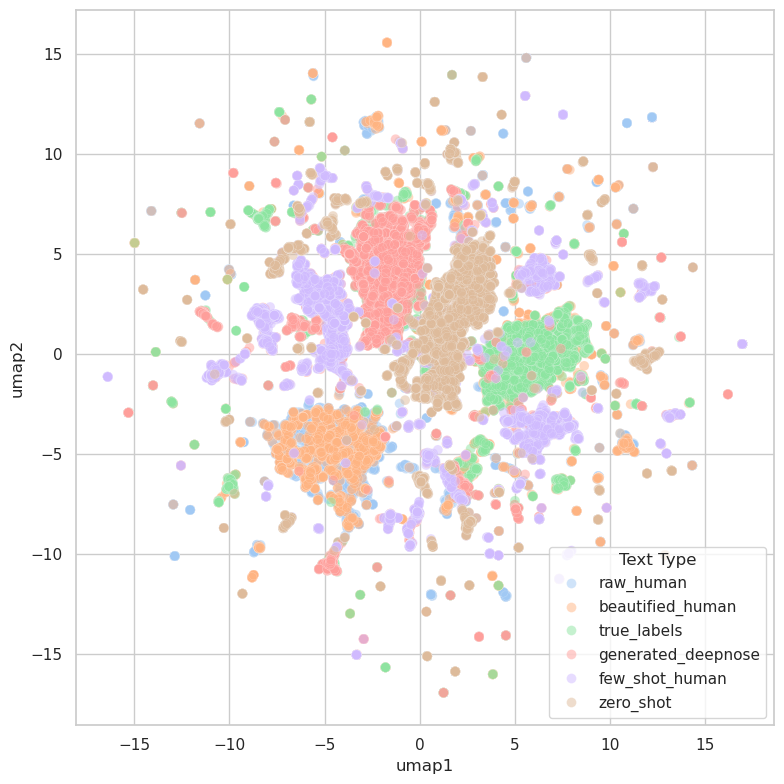

In [607]:
plt.figure(figsize=(8, 8))

sns.scatterplot(data=df_umap,
                x="umap1", y="umap2",
                hue="sent_type", marker="o", 
                edgecolor="white", lw=0.2, alpha=0.5,
                palette="pastel", s=50)
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()

In [611]:
include_cols = ["beautified_human"]
embed_data = np.stack(embeddings[include_cols].values.flatten())    # (10124, 2) -> (20248,)
scaled_embed_data = StandardScaler().fit_transform(embed_data)
reducer = umap.UMAP(random_state=42)
umap_embeddings = reducer.fit_transform(scaled_embed_data)
df_umap = pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
labels = []
for col in include_cols:
    labels.extend([col] * 10124)

df_umap["dataset"] = embeddings.Dataset.to_list() * len(include_cols)
df_umap["sent_type"] = labels
df_umap["bow"] = fill_bow

/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
from collections import Counter
word_counts = Counter([word for lst in fill_bow for word in lst])

In [653]:
percept_groups = {
    #"fruity": ["fruity"],
    "floral": ["jasmin", "rose", "lavender"],
    "meaty": ["savory", "beefy", "roasted"],
    "ethereal": ["cognac", "fermented", "alcoholic", "ethereal"],
    #"sweet": ["sweet"],
    "musk": ["musk"],
    "garlic": ["garlic"],
    "odorless": ["odorless"]
                 }

In [615]:
percept_groups = {k:[k] for k in ["rose", "meaty", "roasted", "musk", "garlic", "odorless"]}

In [654]:
perc_types = []
for lst in df_umap.bow.values:
    temp = []
    for word in lst:
        for k, v in percept_groups.items():
            if word in v:
                temp.append(k)
    perc_types.append(list(set(temp)))
df_umap["perc_types"] = perc_types
#groups_include = ["fruity", "floral", "meaty", "ethereal", "odorless"]
groups_include = list(percept_groups.keys())
for group in groups_include:
    flag = []
    for ix in df_umap.index:
        current_perc = df_umap.perc_types.values[ix]
        flag.append(group in current_perc)
    df_umap[group] = flag

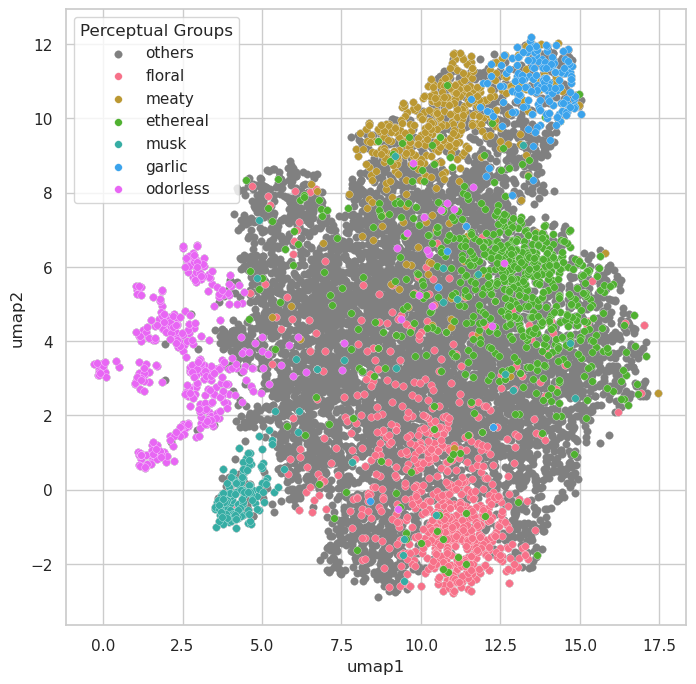

In [655]:
plt.figure(figsize=(8, 8))
sns.set_theme(style="whitegrid", palette="husl")
colors = sns.color_palette("husl", len(percept_groups))

sns.scatterplot(data=df_umap,
                x="umap1", y="umap2",
                marker="o", color="grey",
                edgecolor="grey", lw=0.2, 
                label="others", s=30)

for ix, group in enumerate(percept_groups.keys()):
    sns.scatterplot(data=df_umap.loc[df_umap[group]==True],
                    x="umap1", y="umap2",
                    color = colors[ix],
                    label=group,
                    marker="o", 
                    edgecolor="white", lw=0.2, s=30)

plt.legend(title="Perceptual Groups", loc="upper left")
plt.show()

In [71]:
def get_umap(embeddings=embeddings,
             n_neighbors=10, min_dist=0.1, 
             percept_groups={k:[k] for k in ["rose", "meaty", "roasted", "musk", "garlic", "odorless"]}):
    include_cols = ["CHD"]
    embed_data = np.stack(embeddings[include_cols].values.flatten())    
    scaled_embed_data = StandardScaler().fit_transform(embed_data)
    reducer = umap.UMAP(random_state=123, n_neighbors=n_neighbors, min_dist=min_dist)
    umap_embeddings = reducer.fit_transform(scaled_embed_data)
    df_umap = pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    labels = []
    for col in include_cols:
        labels.extend([col] * 10124)
    df_umap["dataset"] = embeddings.Dataset.to_list() * len(include_cols)
    df_umap["sent_type"] = labels

    fill_bow = []
    
    for ix in embeddings.index:
        cid = embeddings.iloc[ix]["CID"]
        ds = embeddings.iloc[ix]["Dataset"]
        try:
            fill_bow.append(merged.loc[merged.CID == cid].loc[merged.Dataset == ds]["BagOfWords"].values[0][2:-2].replace("'", "").replace(" ", "").split(","))
        except:
            #print(cid)
            #print(ds)
            fill_bow.append([])
    
    df_umap["bow"] = fill_bow   
    perc_types = []
    for lst in df_umap.bow.values:
        temp = []
        for word in lst:
            for k, v in percept_groups.items():
                if word in v:
                    temp.append(k)
        perc_types.append(list(set(temp)))
    df_umap["perc_types"] = perc_types
    groups_include = list(percept_groups.keys())
    for group in groups_include:
        flag = []
        for ix in df_umap.index:
            current_perc = df_umap.perc_types.values[ix]
            flag.append(group in current_perc)
        df_umap[group] = flag
    return df_umap

/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/khue/anaconda3/envs/umap/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


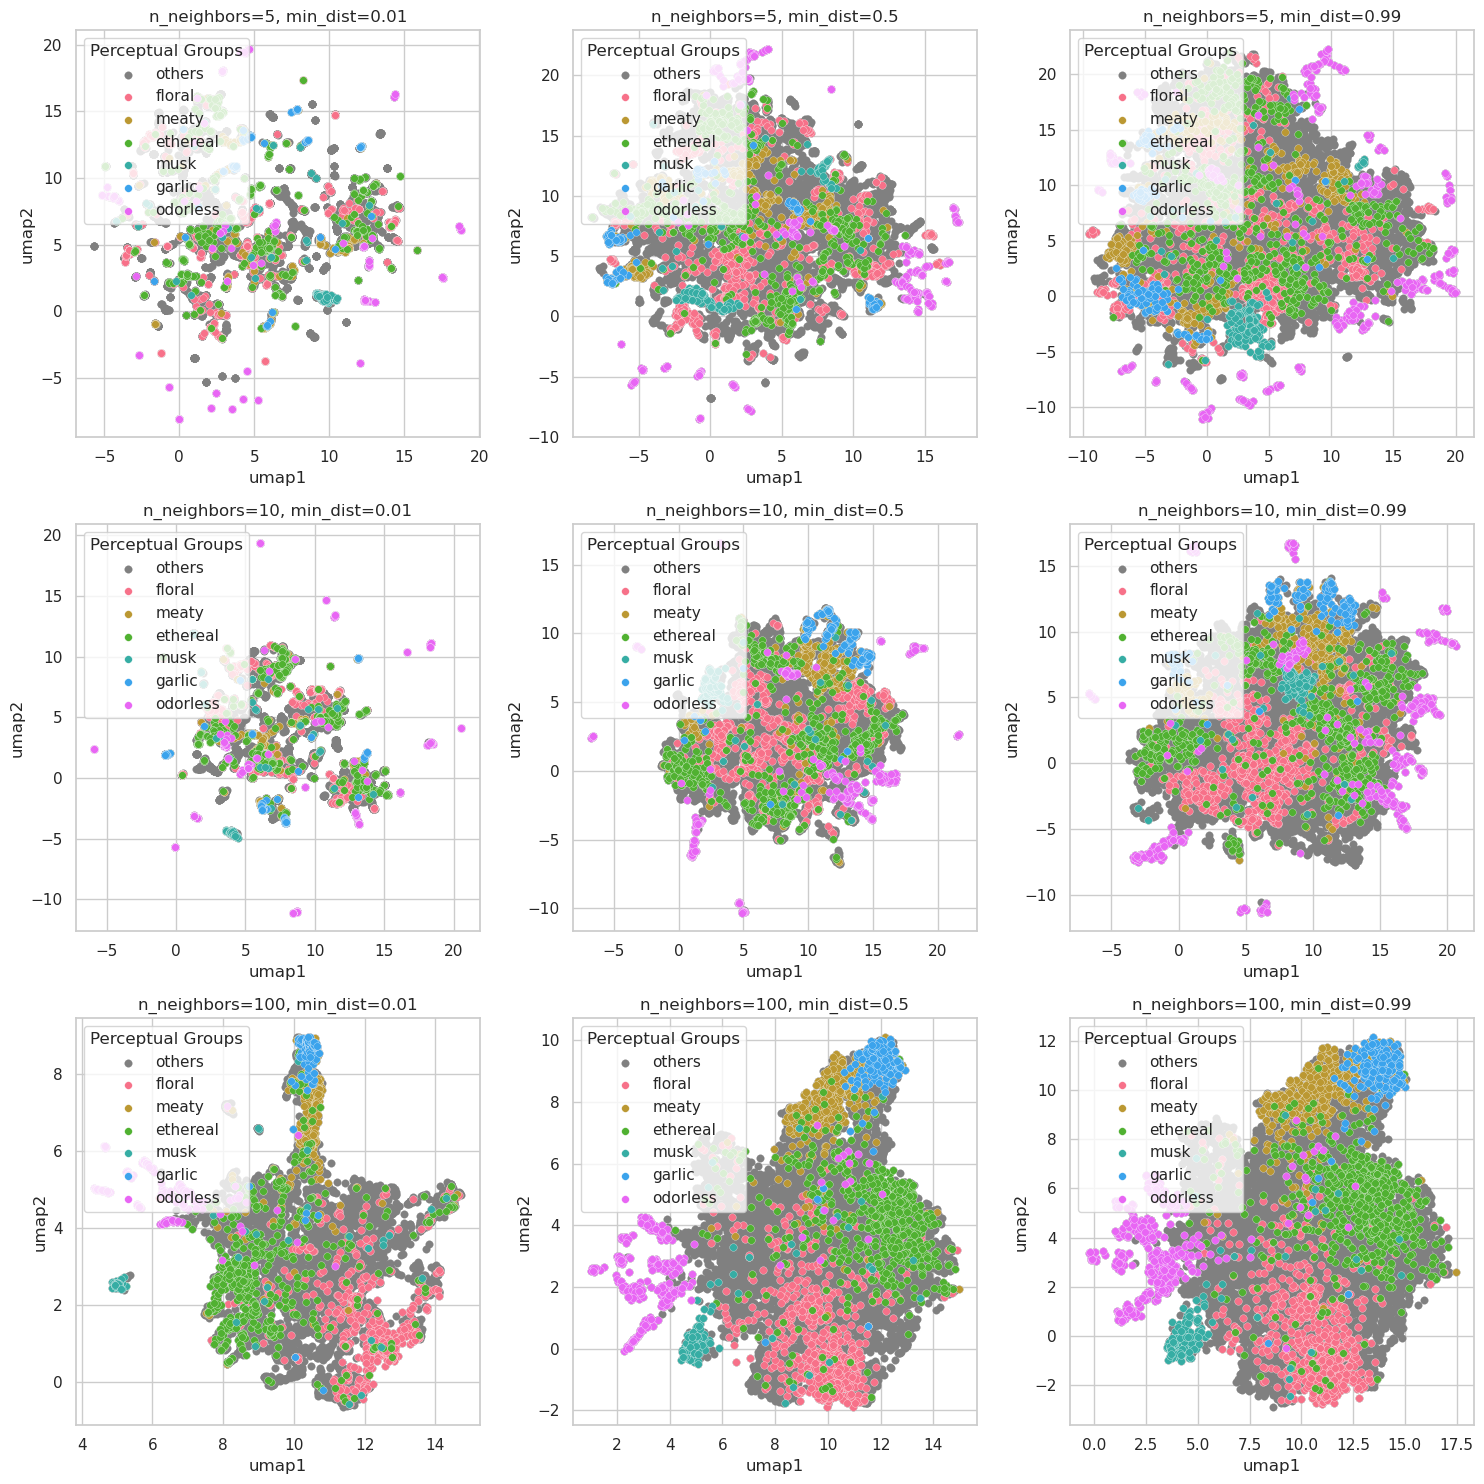

In [675]:
sns.set_theme(style="whitegrid", palette="husl")
_, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

if 1:
    percept_groups = {
    #"fruity": ["fruity"],
    "floral": ["jasmin", "rose", "lavender"],
    "meaty": ["savory", "beefy", "roasted"],
    "ethereal": ["cognac", "fermented", "alcoholic", "ethereal"],
    #"sweet": ["sweet"],
    #"fishy": ["fishy"],
    "musk": ["musk"],
    "garlic": ["garlic"],
    "odorless": ["odorless"]
                 }
else:
    percept_groups={k:[k] for k in ["muguet", "lavender", "jasmin", "rose", \
                                    "cognac", "fermented", "alcoholic", \
                                    "savory", "beefy", "meaty", "roasted", \
                                    "musk", "garlic", "odorless"]}

colors = sns.color_palette("husl", len(percept_groups))
for iy, (n_neighbors, min_dist) in enumerate(list(itertools.product([5, 10, 100], [0.01, 0.5, 0.99]))):
    sns.set_theme(style="whitegrid", palette="husl")
    axes[iy].set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
    df_umap = get_umap(n_neighbors=n_neighbors, min_dist=min_dist, percept_groups=percept_groups)
    sns.scatterplot(data=df_umap,
                    ax=axes[iy],
                    x="umap1", y="umap2",
                    marker="o", color="grey",
                    edgecolor="grey", lw=0.2, 
                    label="others", s=30)

    for ix, group in enumerate(percept_groups.keys()):
        sns.scatterplot(data=df_umap.loc[df_umap[group]==True],
                        ax=axes[iy],
                        x="umap1", y="umap2",
                        color = colors[ix],
                        label=group,
                        marker="o", 
                        edgecolor="white", lw=0.2, s=30)

    axes[iy].legend(title="Perceptual Groups", loc="upper left")
plt.tight_layout()
plt.savefig("figs/umap_groups_words.pdf", format="pdf", bbox_inches="tight")
plt.show()

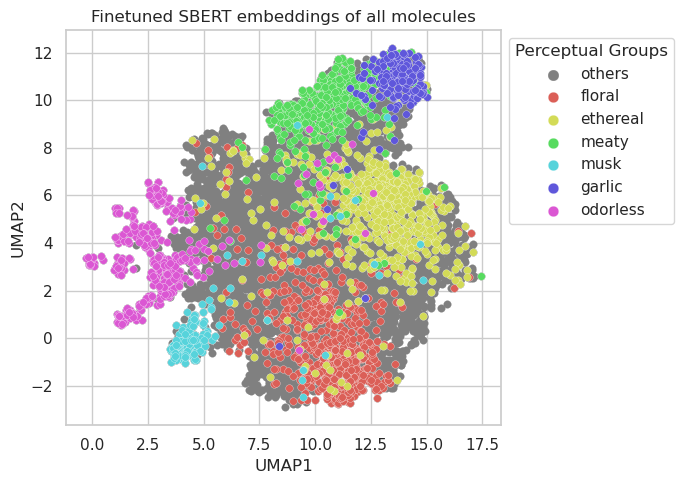

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))

if 1:
    percept_groups = {
    #"fruity": ["fruity"],
    "floral": ["jasmin", "rose", "lavender"],
    "ethereal": ["cognac", "fermented", "alcoholic", "ethereal"],
    "meaty": ["savory", "beefy", "roasted"],
    #"sweet": ["sweet"],
    #"fishy": ["fishy"],
    "musk": ["musk"],
    "garlic": ["garlic"],
    "odorless": ["odorless"]
                 }
else:
    percept_groups={k:[k] for k in ["muguet", "lavender", "jasmin", "rose", \
                                    "cognac", "fermented", "alcoholic", \
                                    "savory", "beefy", "meaty", "roasted", \
                                    "musk", "garlic", "odorless"]}

colors = sns.color_palette("hls", len(percept_groups))
plt.title("Finetuned SBERT embeddings of all molecules")
df_umap = get_umap(n_neighbors=100, min_dist=0.99, percept_groups=percept_groups)
sns.scatterplot(data=df_umap,
                x="umap1", y="umap2",
                marker="o", color="grey",
                edgecolor="grey", lw=0.2, 
                label="others", s=30)

for ix, group in enumerate(percept_groups.keys()):
    sns.scatterplot(data=df_umap.loc[df_umap[group]==True],
                    x="umap1", y="umap2",
                    color = colors[ix],
                    label=group,
                    marker="o", 
                    edgecolor="white", lw=0.2, s=30)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Perceptual Groups", loc="upper left", markerscale=1.4)
ax = plt.gca()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("figs/umap_single_cmap3.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
import pickle

fpath = "/home/khue/cyrille/CIRANO/cosine_similarities"
#fname = "table_cosines_all-MiniLM-L12-v1.sbert_best_left_1.pkl"
#fname = "table_cosines_all-MiniLM-L12-v1.sbert_init.pkl"
fname = "embeddings_all-MiniLM-L12-v1.sbert_init_fold_1.pkl"
#fname = "embeddings_all-MiniLM-L12-v1.sbert_best_left_1_fold_1.pkl"
#fname = "table_cosines_NovaSearch.stella_en_400M_v5.sbert_best_left_1.pkl"
#fname = "table_cosines_NovaSearch.stella_en_400M_v5.sbert_init.pkl"

'''
for fn in ["table_cosines_all-MiniLM-L12-v1.sbert_best_left_1.pkl", 
           "table_cosines_all-MiniLM-L12-v1.sbert_init.pkl", 
          "table_cosines_NovaSearch.stella_en_400M_v5.sbert_best_left_1.pkl", 
           "table_cosines_NovaSearch.stella_en_400M_v5.sbert_init.pkl"]:
'''
print(f"file: {fn}")
with open(f"{fpath}/{fname}", "rb") as f:
    df = pickle.load(f)

file: table_cosines_NovaSearch.stella_en_400M_v5.sbert_init.pkl


In [44]:
def prep_data(fname, fpath="/home/khue/cyrille/CIRANO/cosine_similarities"):
    print(f"file: {fname}")
    with open(f"{fpath}/{fname}", "rb") as f:
        df = pickle.load(f)
    df.rename(columns={"Human descriptions": "HD",
                        "Beautified human descriptions": "CHD",
                        "Beautified human labels": "CHL",
                        "Beautified DeepNose descriptions": "CDL", 
                        "Beautified DeepNose labels": "DL",
                        "Human labels": "HL",
                        "From SMILES - zero shot": "S+ZS",
                        "From SMILES - human examples": "S+HD", 
                        "From SMILES - beautified human examples": "S+CHD", 
                        "From SMILES - beautified labels examples": "S+CHL"
                        }, inplace=True)
    df = df.loc[~pd.isnull(df.index)]
    df = df.reset_index()
    df.CID = df.CID.astype(int)
    return df

In [53]:
fpath = "/home/khue/cyrille/CIRANO/datasets/cross_validation"

test_cids = []
for fname in [f"fold_{i}.npz" for i in range(1, 6)]:
    idx = np.load(f"{fpath}/{fname}")["testset_cids"]
    test_cids.append(idx.astype(int))

In [67]:
df_list = []
for i in range(1, 6):
    df = prep_data(f"embeddings_all-MiniLM-L12-v1.sbert_best_left_{i}_fold_{i}.pkl")
    df = df.loc[df.CID.isin(test_cids[i-1])]
    df_list.append(df)

small_ft = pd.concat(df_list).reset_index(drop=True)

df_list = []
for i in range(1, 6):
    df = prep_data(f"embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_{i}_fold_{i}.pkl")
    df = df.loc[df.CID.isin(test_cids[i-1])]
    df_list.append(df)

big_ft = pd.concat(df_list).reset_index(drop=True)

small_init = prep_data("embeddings_all-MiniLM-L12-v1.sbert_init_fold_1.pkl")
big_init = prep_data("embeddings_NovaSearch.stella_en_400M_v5.sbert_init_fold_1.pkl")

file: embeddings_all-MiniLM-L12-v1.sbert_best_left_1_fold_1.pkl
file: embeddings_all-MiniLM-L12-v1.sbert_best_left_2_fold_2.pkl
file: embeddings_all-MiniLM-L12-v1.sbert_best_left_3_fold_3.pkl
file: embeddings_all-MiniLM-L12-v1.sbert_best_left_4_fold_4.pkl
file: embeddings_all-MiniLM-L12-v1.sbert_best_left_5_fold_5.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_1_fold_1.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_2_fold_2.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_3_fold_3.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_4_fold_4.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_best_left_5_fold_5.pkl
file: embeddings_all-MiniLM-L12-v1.sbert_init_fold_1.pkl
file: embeddings_NovaSearch.stella_en_400M_v5.sbert_init_fold_1.pkl


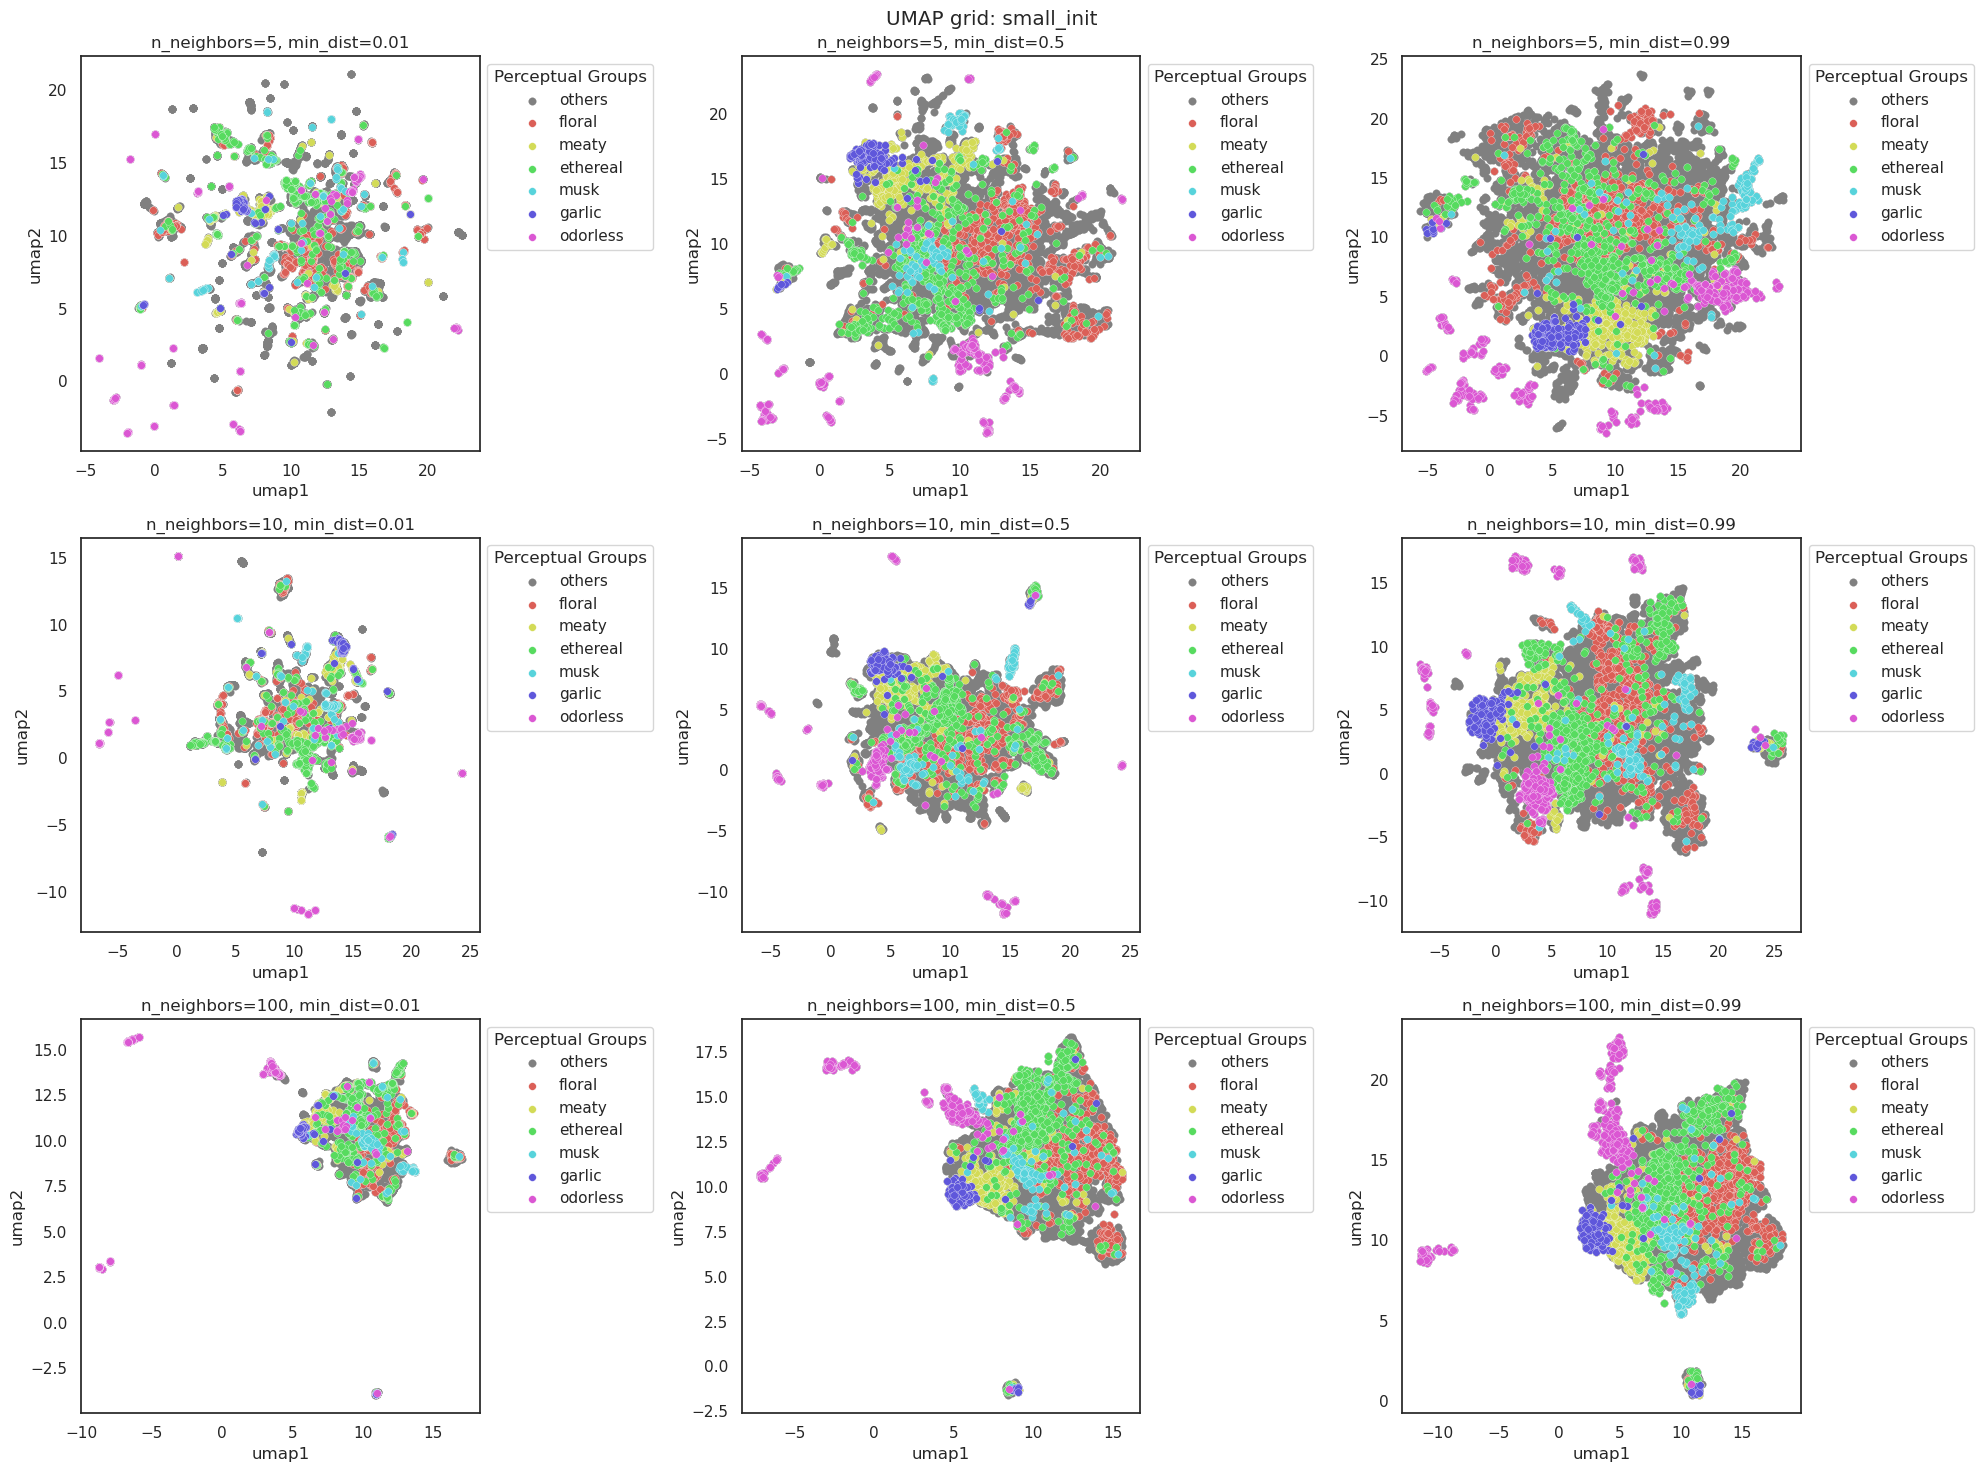

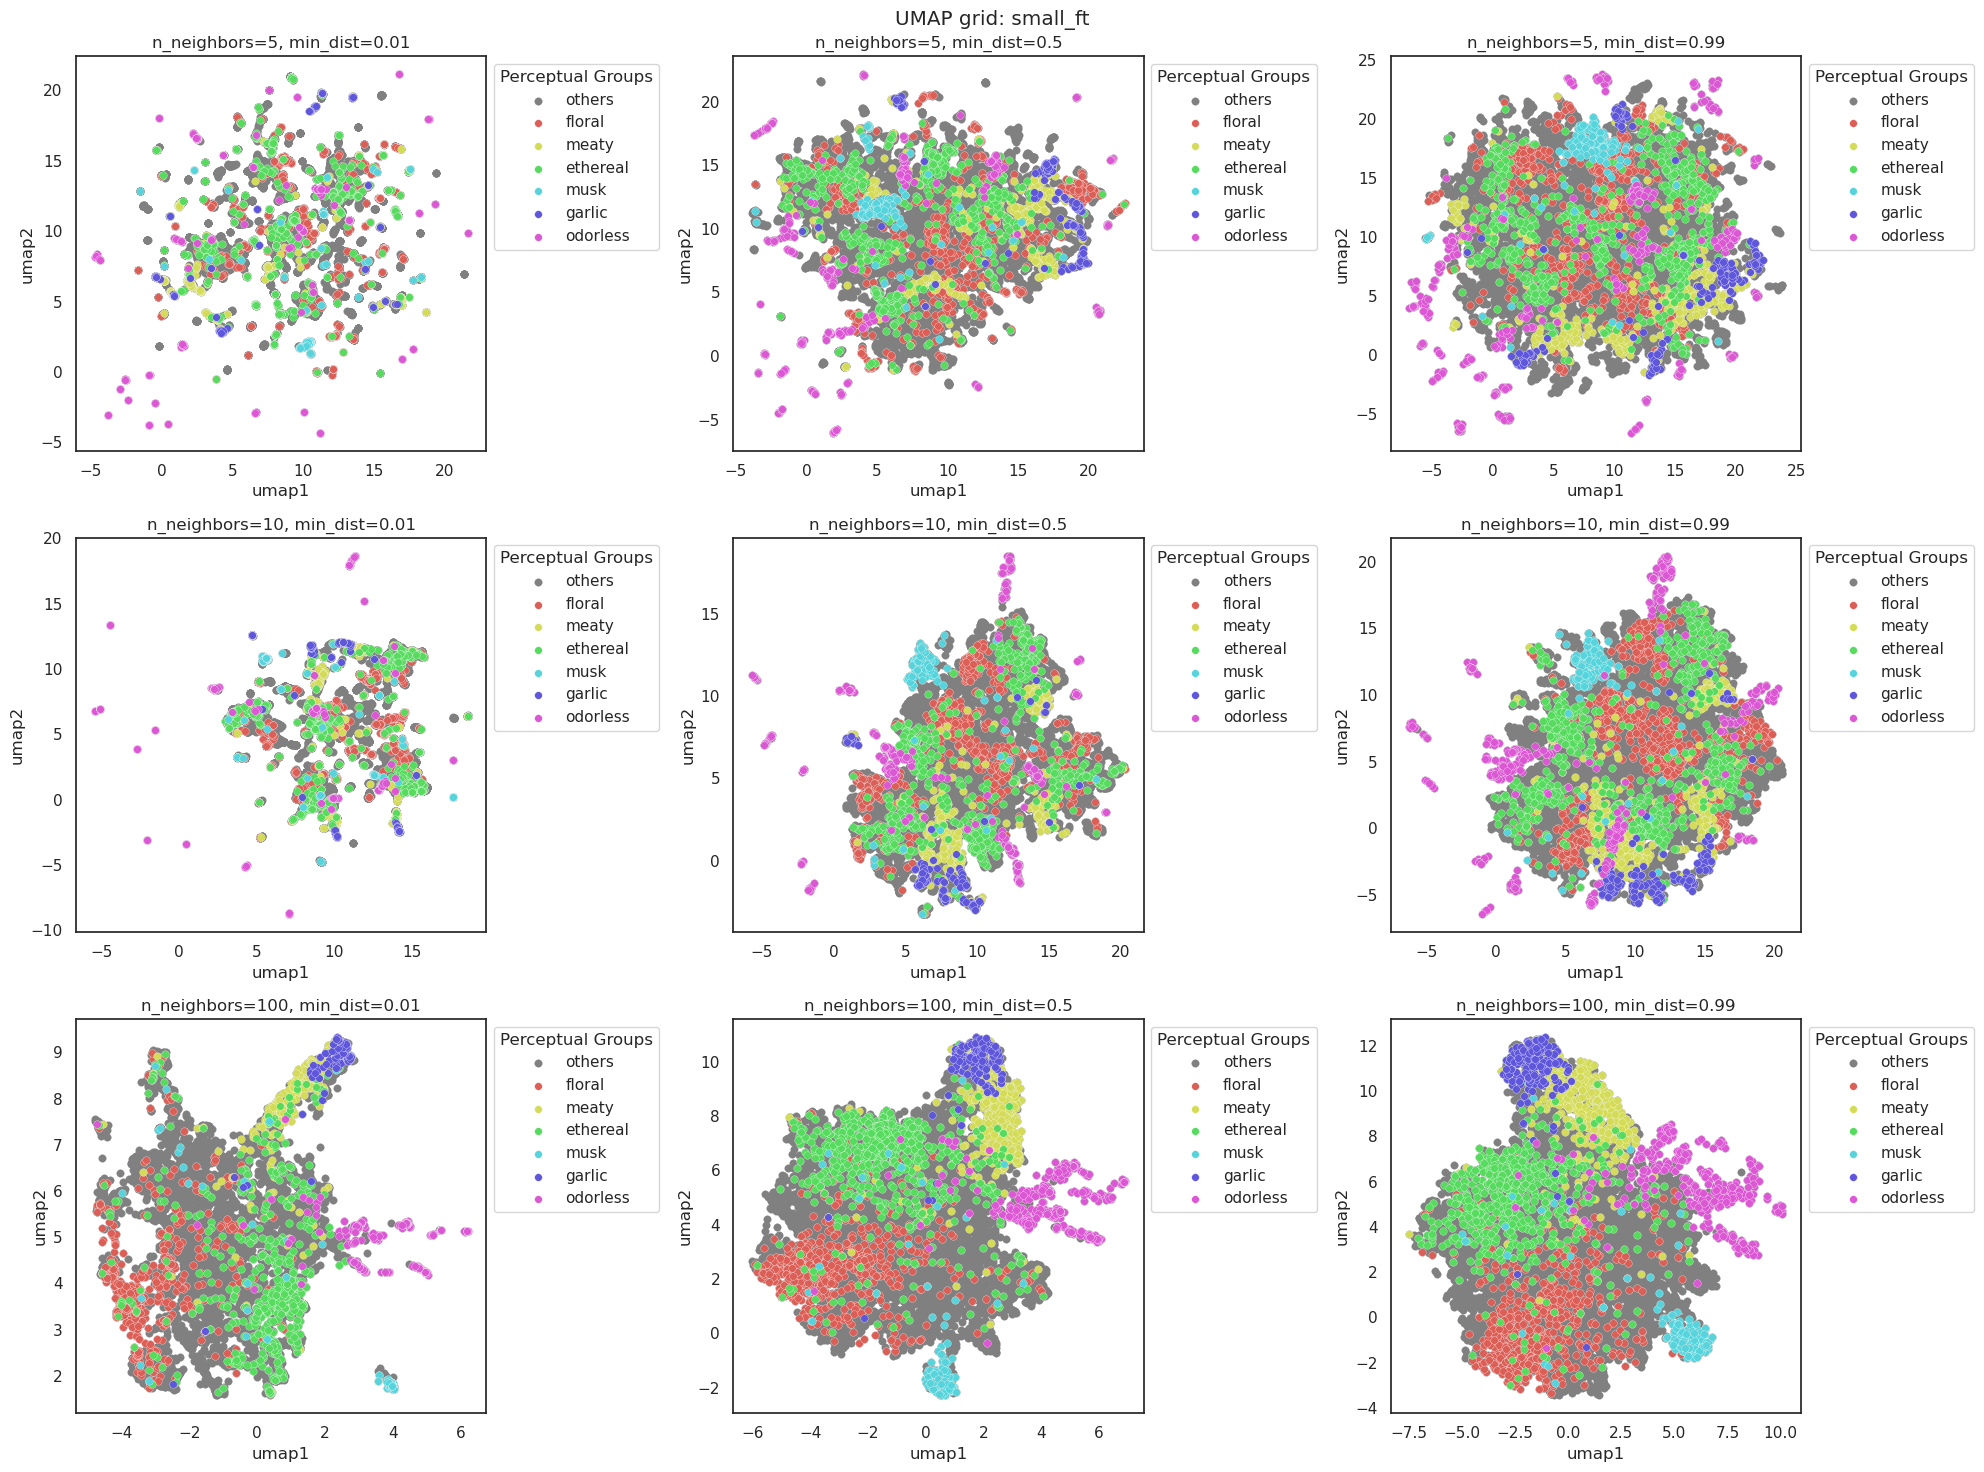

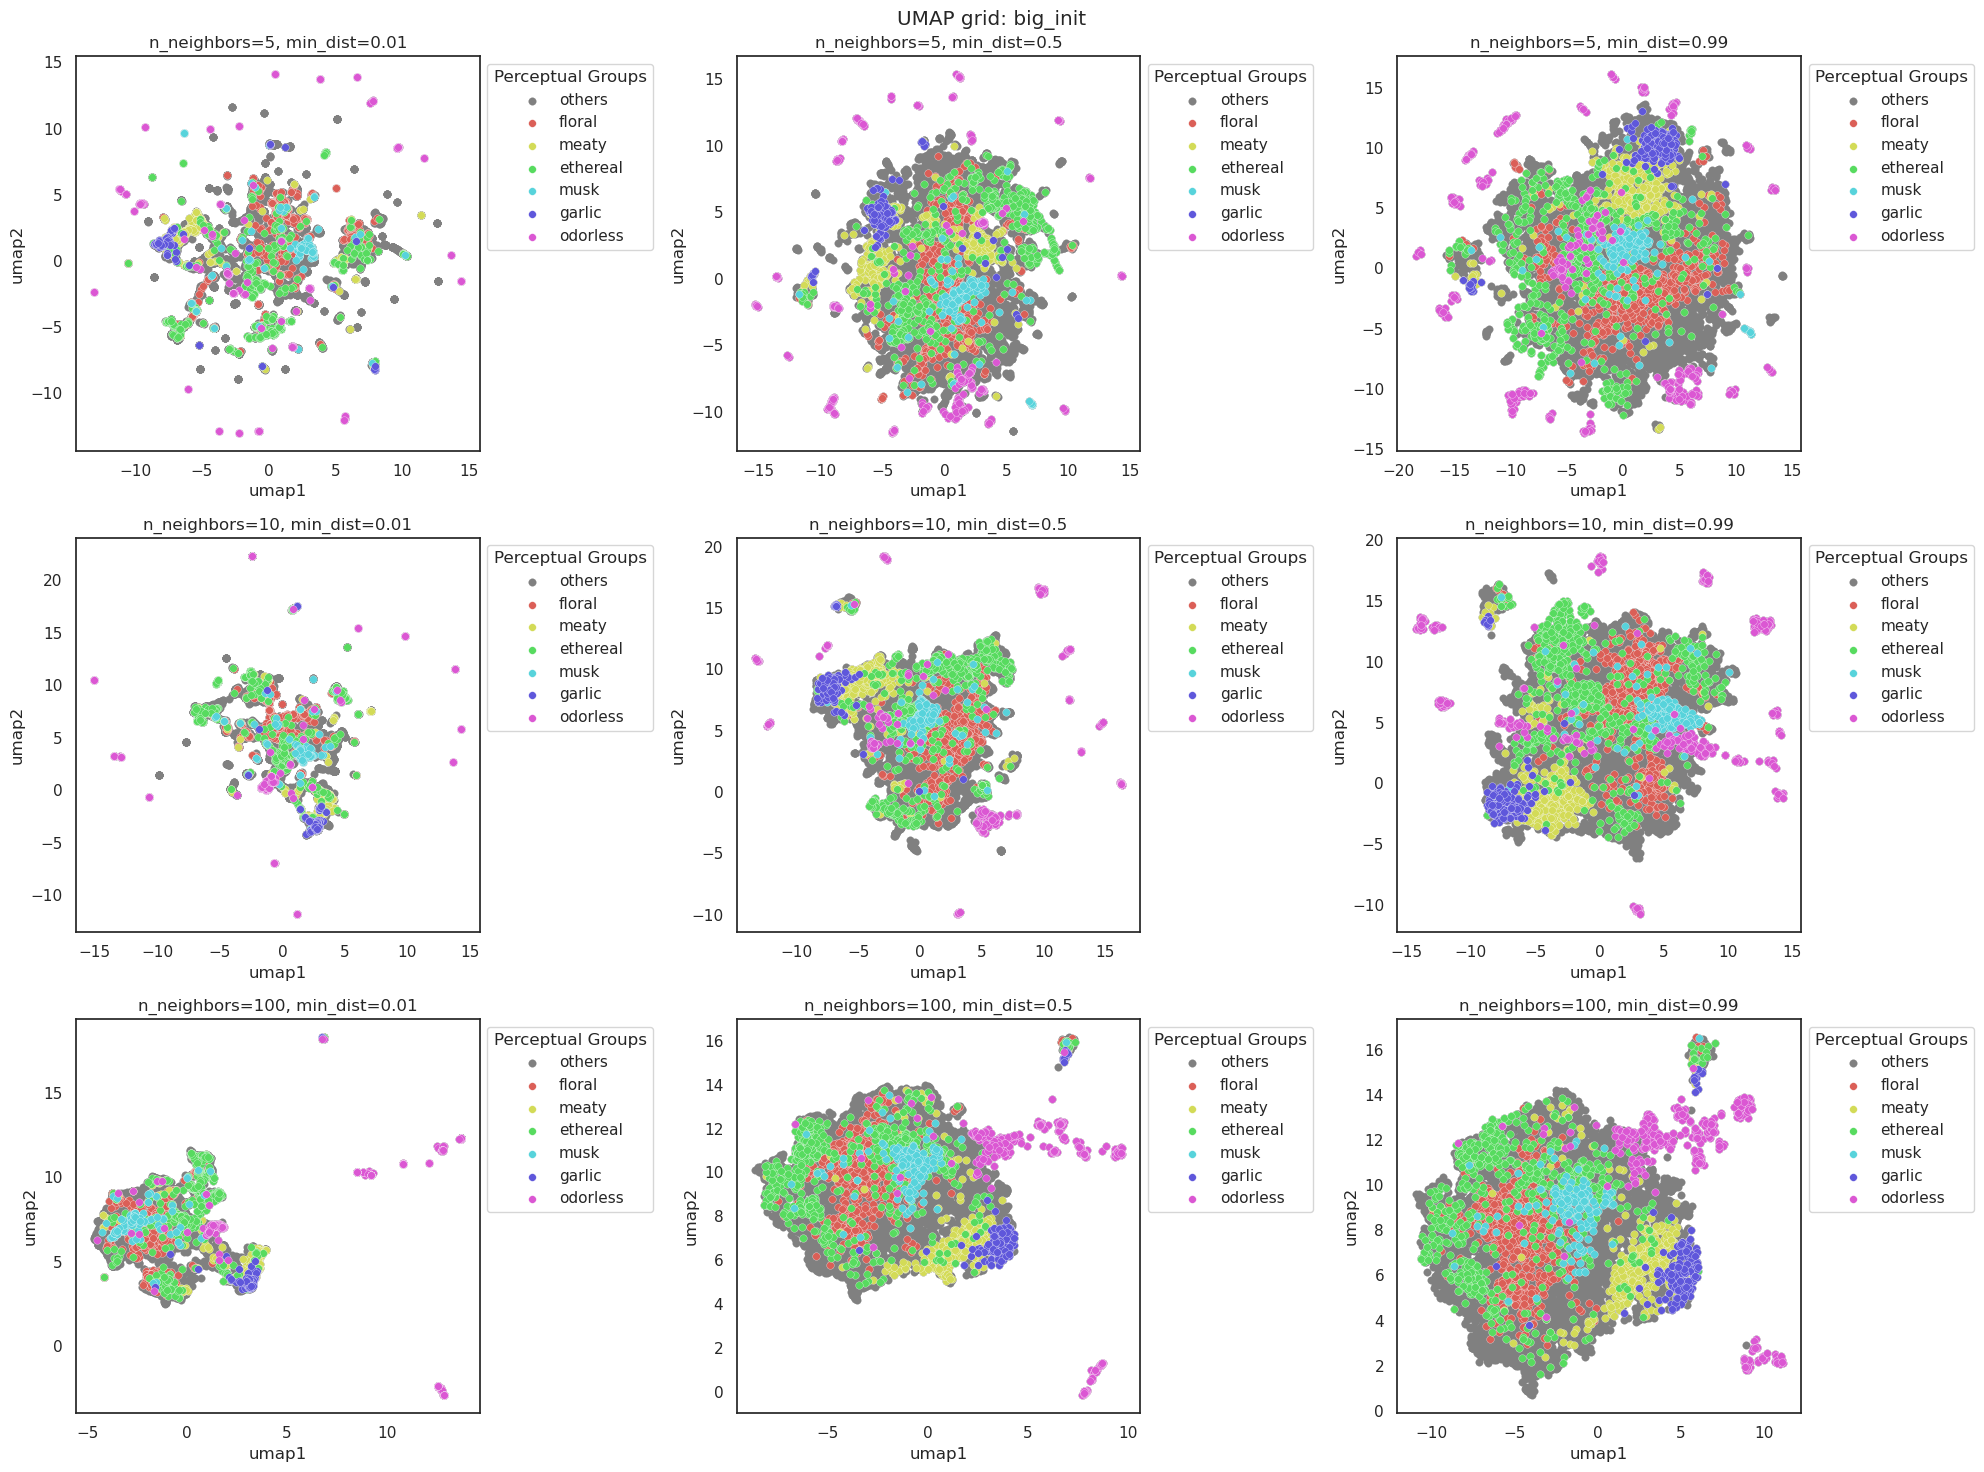

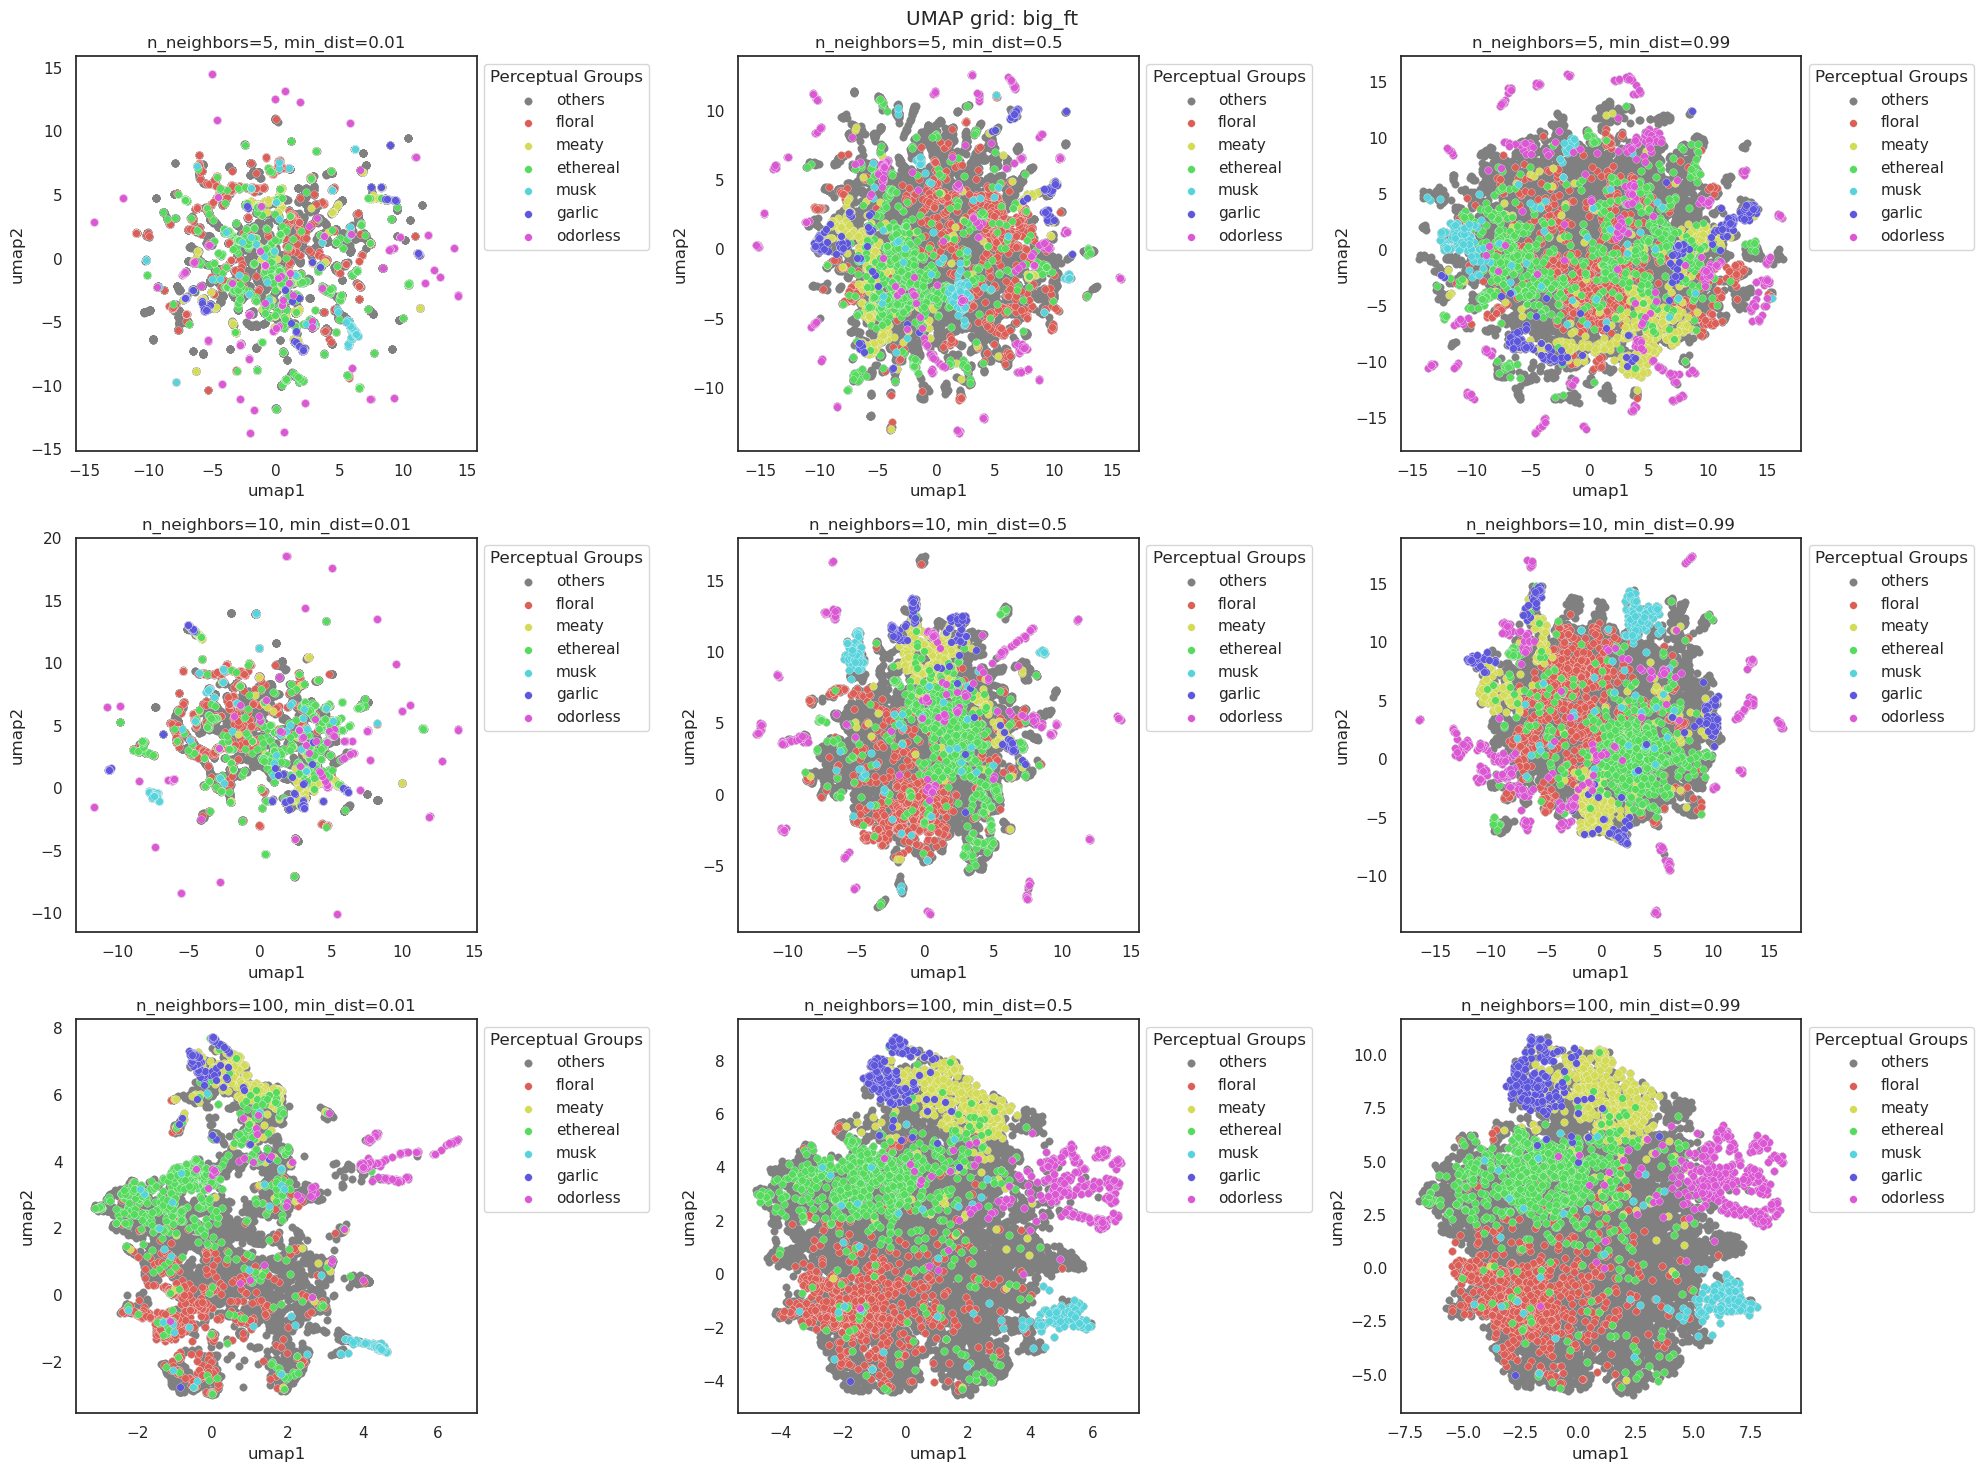

In [72]:
for df, fsave in zip([small_init, small_ft, big_init, big_ft],
                    ["small_init", "small_ft", "big_init", "big_ft"]):

    sns.set_theme(style="white", palette="hls")
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle(f"UMAP grid: {fsave}")
    axes = axes.flatten()
    if 1:
        percept_groups = {
        #"fruity": ["fruity"],
        "floral": ["jasmin", "rose", "lavender"],
        "meaty": ["savory", "beefy", "roasted"],
        "ethereal": ["cognac", "fermented", "alcoholic", "ethereal"],
        #"sweet": ["sweet"],
        #"fishy": ["fishy"],
        "musk": ["musk"],
        "garlic": ["garlic"],
        "odorless": ["odorless"]
                     }
    else:
        percept_groups={k:[k] for k in ["muguet", "lavender", "jasmin", "rose", \
                                        "cognac", "fermented", "alcoholic", \
                                        "savory", "beefy", "meaty", "roasted", \
                                        "musk", "garlic", "odorless"]}
    
    colors = sns.color_palette("hls", len(percept_groups))
    for iy, (n_neighbors, min_dist) in enumerate(list(itertools.product([5, 10, 100], [0.01, 0.5, 0.99]))):
        axes[iy].set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
        df_umap = get_umap(embeddings=df,
                           n_neighbors=n_neighbors, min_dist=min_dist, 
                           percept_groups=percept_groups)
        sns.scatterplot(data=df_umap,
                        ax=axes[iy],
                        x="umap1", y="umap2",
                        marker="o", color="grey",
                        edgecolor="grey", lw=0.2, 
                        label="others", s=30)
    
        for ix, group in enumerate(percept_groups.keys()):
            sns.scatterplot(data=df_umap.loc[df_umap[group]==True],
                            ax=axes[iy],
                            x="umap1", y="umap2",
                            color = colors[ix],
                            label=group,
                            marker="o", 
                            edgecolor="white", lw=0.2, s=30)
    
        axes[iy].legend(title="Perceptual Groups", loc="upper left")
        sns.move_legend(axes[iy], "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f"figs/umap_grid_{fsave}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [24]:
df = pd.read_csv("/home/khue/cyrille/CIRANO/embeddings/all-MiniLM-L12-v1_1.csv", delimiter="$")
df.Dataset.value_counts()

Dataset
goodscents     6816
leffingwell    3523
arctander      3050
Name: count, dtype: int64